Your task is to train *character-level* language models. 
You will train unigram, bigram, and trigram character level models on a collection of books from Project Gutenberg. You will then use these trained English language models to distinguish English documents from Brazilian Portuguese documents in the test set.

In [0]:
import pandas as pd
import httpimport

with httpimport.remote_repo(['lm_helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from lm_helper import get_train_data, get_test_data

This code loads the training and test data. Each dataset is a list of books. Each book contains a list of sentences, and each sentence contains a list of words. For building a character language model, you should join the words of a sentence together with a space character.

In [0]:
# get the train and test data
train = get_train_data()
test, test_files = get_test_data()
#test2, test_files = get_test_data()

In [0]:
print(len(train))
print(len(test))

18
220


## 1.1
Collect statistics on the unigram, bigram, and trigram character counts.

If your machine takes a long time to perform this computation, you may save these counts to files in your github repository and load them on request. This is not necessary, however.

In [0]:
from sklearn.model_selection import train_test_split
import string
import re
import nltk
from nltk.collections import Counter
from nltk import bigrams, trigrams
import csv
import math

In [0]:
#convert list of list per book into list per book in training set

## Join the words in train set by space except for punctuations and single letters (except article a/A) as they are immediately followed by letter. ##
#Example: ['can', "'", 't'] ==> can't and ['a', 'world', '!'] ==> a world!

train_new = []
for book in train:
  tmp = []
  for sentence in book: #start of sentence adding space as indicator
    for word in sentence:
        if word == 'a' or word == 'A': # single 'a' as elemnt means it is article, so space is included
          tmp.extend([' ',word.lower()]) #simultanously converting to lower case words
        elif word in string.punctuation:
          tmp.extend(word)
        elif re.match('\b[a-zA-Z0-9]\b', word):
          tmp.extend(word.lower())
        else:
          tmp.extend([' ',word.lower()])
     
    #end of sentence respective punctuations serves as end of sentence indicator
  train_new.append(tmp)

X_train, X_val = train_test_split(train_new, train_size = 0.8, test_size = 0.2, random_state = 123)
print(len(X_train))
print(len(X_val))

14
4


In [0]:
# Join the list elements to string and then split into list of characters to count unigram, bigram and trigram #

X_train_new = []
for book in X_train:
  tmp = ''.join(book)
  X_train_new.extend([tmp]) #list of books (where books are list of words)

X_train_new = ' '.join(X_train_new) #join each book into single list
X_train_new = list(X_train_new) #split by character
print(len(X_train_new))

X_val_new = []
for book in X_val:
  tmp = ''.join(book)
  X_val_new.extend([tmp]) #list of books (where books are list of words)

X_val_new = ' '.join(X_val_new) #join each book into single list
X_val_new = list(X_val_new) #split by character
len(X_val_new)

10195559


1516574

In [0]:
## Get the count statistics fro unigrams, bigrams and trigrams ##

unigrams_c = Counter(X_train_new)
for uni, count in unigrams_c.items():
  if count <= 60:
    X_train_new[:] = ['UNK' if ch == uni else ch for ch in X_train_new] #replace the chracter with less than 60 occurances ('&': 60, '$': 11, '\x1a': 2, '=': 1, '>': 1)as UNK in original data
#then get the count again Or we can directly update in count dictionary but update in list of characters will yield to 
#the next bigram and trigrams count calculation

unigrams_c = Counter(X_train_new) #run again to consider 'UNK'
bigrams_gen = bigrams(X_train_new)  #using builtin nltk function for the updated list
trigrams_gen = trigrams(X_train_new)
bigrams_c = Counter(bigrams_gen)
trigrams_c = Counter(trigrams_gen)


unigrams_len = len(unigrams_c)
unigrams_tot = sum(unigrams_c.values())

#Respective probabilities using MLE for linear interpolation

unigram_prob_i = {uni:count/unigrams_tot for uni, count in unigrams_c.items()} #natural log
bigram_prob_i = {big:count/unigrams_c[big[0]] for big, count in bigrams_c.items()}
trigram_prob_i = {tri:count/bigrams_c[tri[:2]] for tri, count in trigrams_c.items()}

In [0]:
#Output is lengthy hence storing in csv file attached in github

#print("Unigrams Count: ", unigrams_c)
#print("Bigrams Count: ", bigrams_c)
#print("Trigrams Count: ", trigrams_c)


## 1.2
Calculate the perplexity for each document in the test set using linear interpolation smoothing method. For determining λs for linear interpolation, you can divide the training data into a new training set (80%) and a held-out set (20%), then using grid search method:
Choose ~10 values of λ to test using grid search on held-out data.

Some documents in the test set are in Brazilian Portuguese. Identify them as follows: 
  - Sort by perplexity and set a cut-off threshold. All the documents above this threshold score should be categorized as Brazilian Portuguese. 
  - Print the file names (from `test_files`) and perplexities of the documents above the threshold

    ```
        file name, score
        file name, score
        . . .
        file name, score
    ```

  - Copy this list of filenames and manually annotate them as being correctly or incorrectly labeled as Portuguese.




In [0]:
#from sklearn.model_selection import ParameterGrid
#param_grid = {'ld1':[0.3,0.35,0.2,0.25,0.1,0.15,0.05,0.33,0.2,0.1], 'ld2':[0.3,0.35,0.2,0.25,0.1,0.15,0.05,0.33,0.6,0.8], 'ld3':[0.4,0.3,0.6,0.5,0.8,0.7,0.9,0.34,0.2,0.1]}
grid = [[0.3,0.3,0.4], [0.35, 0.35, 0.3], [0.2,0.2,0.6], [0.25,0.25,0.5],[0.1,0.1,0.8],[0.125,0.125,0.75], [0.15,0.15,0.7], [0.075,0.075,0.85], [0.05,0.05,0.9], [0.33,0.33,0.34], [0.2,0.6,0.2],[0.1,0.8,0.1]]
#for lds,vals in param_grid.items():

X_val_new = ['UNK' if ch not in unigrams_c.keys() else ch for ch in X_val_new]
#unigrams_gen_val = X_val_new 
#bigrams_gen_val = bigrams(X_val_new)  
#trigrams_gen_val = trigrams(X_val_new)

In [0]:
perplexity = []
for j, lds in enumerate(grid):
  tmp = []
  trigrams_gen_val = trigrams(X_val_new)
  for i, tri in enumerate(trigrams_gen_val): #for each trigram in hold-out data
    prob = (lds[0]*unigram_prob_i.get(tri[0],0)) + (lds[1]*bigram_prob_i.get(tri[:2],0)) + (lds[2]*trigram_prob_i.get(tri,0))
    tmp.append(math.log(prob)) #each character/trigram log probability
    #print(j,i) #"Lambdas and trigrams #: "
  perplexity.append(math.exp(-(sum(tmp)/len(tmp)))) #save perplexity for each grid of lambda
  #print(j)

In [0]:
print(perplexity)
grid[perplexity.index(min(perplexity))]

[6.833403513292825, 7.195358730850224, 6.453139793039058, 6.594688949043672, 6.452712767743245, 6.412696024280412, 6.401800480908608, 6.529355800890763, 6.657355446773375, 7.033037527250558, 7.278016786676057, 8.029060076846763]


[0.15, 0.15, 0.7]

***Hence lambda 1 = 0.15, lambda 2 = 0.15 and lambda 3 = 0.7*** 
Will be used for interpolation.

In [0]:
test_new = []
for book in test:
  tmp = []
  for sentence in book: #start of sentence adding space as indicator
    for word in sentence:
        if word == 'a' or word == 'A': # single 'a' as elemnt means it is article, so space is included
          tmp.extend([' ',word.lower()]) #simultanously converting to lower case words
        elif word in string.punctuation:
          tmp.extend(word)
        elif re.match('\b[a-zA-Z0-9]\b', word):
          tmp.extend(word.lower())
        else:
          tmp.extend([' ',word.lower()])
     
    #end of sentence respective punctuations serves as end of sentence indicator
  test_new.append(tmp)


In [0]:
test = []
for book in test_new:
  tmp = ''.join(book)
  test.append(list(tmp)) #list of characters in each test documents

for i in range(len(test)):
  test[i] = ['UNK' if ch not in unigrams_c.keys() else ch for ch in test[i]]

test_per_1 = []
for j, book in enumerate(test):
  trigrams_gen_test = trigrams(book)
  tmp = []
  for i, tri in enumerate(trigrams_gen_test): 
    prob = (0.15*unigram_prob_i.get(tri[0],0)) + (0.15*bigram_prob_i.get(tri[:2],0)) + (0.7*trigram_prob_i.get(tri,0))
    tmp.append(math.log(prob)) 
    #print(j,i)
  test_per_1.append(math.exp(-(sum(tmp)/len(tmp)))) #each test documents perplexicity
  #print(j)

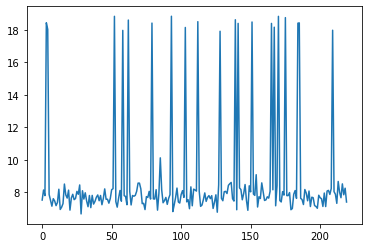

In [0]:
import matplotlib.pyplot as plt
plt.plot(test_per_1)
plt.show()

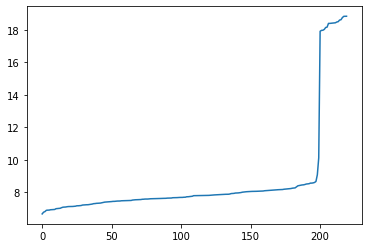

In [0]:
import matplotlib.pyplot as plt
plt.plot(sorted(test_per_1))
plt.show()

In [0]:
## Considering 0.22 as the threshold perplexicity ##
print("File Name, Perplexity")
[(j, round(i,4)) for (i,j) in zip(test_per_1, test_files) if i > 14]

***All of the Brazillian Portugese documents are correctly labelled as Portugese***

File Name, Perplexity

('br94ab02.txt', 17.9131)

('br94ju01.txt', 17.9665)

('ag94fe1.txt', 17.9754)

 ('br94de01.txt', 18.0272)

 ('br94jl01.txt', 18.1458)

 ('ag94ja11.txt', 18.1627)

 ('ag94se06.txt', 18.8318)

 ('ag94jl12.txt', 18.3951)

 ('br94ja04.txt', 18.3968)

 ('ag94ou04.txt', 18.4091)
 
 ('br94ag01.txt', 18.4155)

 ('ag94ag02.txt', 18.4268)

 ('br94ma01.txt', 18.4344)

 ('ag94no01.txt', 18.4821)

 ('br94fe1.txt', 18.5032)

 ('ag94mr1.txt', 18.6018)

 ('ag94de06.txt', 18.6209)

 ('ag94ab12.txt', 18.752)

 ('ag94ma03.txt', 18.8305)
 
 ('ag94ju07.txt', 18.8364)

 
 

## 1.3
Build a trigram language model with add-λ smoothing (use λ = 0.1).

Sort the test documents by perplexity and perform a check for Brazilian Portuguese documents as above:

  - Observe the perplexity scores and set a cut-off threshold. All the documents above this threshold score should be categorized as Brazilian Portuguese. 
  - Print the file names and perplexities of the documents above the threshold

  ```
      file name, score
      file name, score
      . . .
      file name, score
  ```

  - Copy this list of filenames and manually annotate them for correctness.

In [0]:
test = []
for book in test_new:
  tmp = ''.join(book)
  test.append(list(tmp)) #list of characters in each test documents

for i in range(len(test)):
  test[i] = ['UNK' if ch not in unigrams_c.keys() else ch for ch in test[i]]

test_per_k = []
for j, book in enumerate(test):
  trigrams_gen_test = trigrams(book)
  tmp = []
  for i, tri in enumerate(trigrams_gen_test): 
    prob = (trigrams_c.get(tri,0.1))/((0.1*unigrams_len)+bigrams_c.get(tri[:2],0))   ## consider count first then add k=0.1 divide by kV+count of bigrams
    tmp.append(math.log(prob)) 
    #print(j,i)
  test_per_k.append(math.exp(-(sum(tmp)/len(tmp)))) #each test documents perplexicity

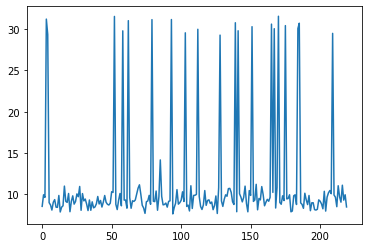

In [0]:
import matplotlib.pyplot as plt
plt.plot(test_per_k)
plt.show()

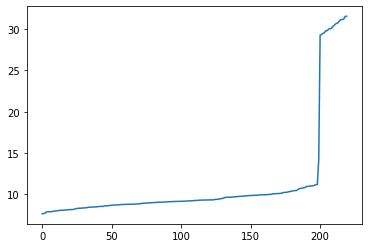

In [0]:
import matplotlib.pyplot as plt
plt.plot(sorted(test_per_k))
plt.show()

In [0]:
## Considering 0.82 as the threshold perplexicity ##
print("File Name, Perplexity")
[(j, round(i,4)) for (i,j) in zip(test_per_k, test_files) if i > 15]


***All of these are correctly labelled as Portugese***
 and remaining documents as English
 
File Name, Perplexity

('ag94ju07.txt', 31.1609)

 ('ag94ja11.txt', 30.0521)

 ('ag94ag02.txt', 30.7164)

 ('ag94fe1.txt', 29.4857)

 ('br94fe1.txt', 29.9807)

 ('br94ma01.txt', 31.2137)

 ('br94ju01.txt', 29.7914)

 ('ag94ma03.txt', 31.5594)

 ('ag94ab12.txt', 30.425)

 ('br94ag01.txt', 31.1495)

 ('br94jl01.txt', 29.5516)

 ('ag94jl12.txt', 30.6051)

 ('br94ja04.txt', 29.8007)

 ('ag94de06.txt', 30.7716)

 ('ag94mr1.txt', 31.0247)

 ('br94de01.txt', 29.3489)

 ('br94ab02.txt', 29.273)

 ('ag94ou04.txt', 30.0676)

 ('ag94se06.txt', 31.5367)

 ('ag94no01.txt', 30.2948)

## 1.4
Based on your observation from above questions, compare linear interpolation and add-λ smoothing by listing out their pros and cons.

Add-k smoothing computed perplexity scores are high compared to linear interpolation. Hence they might not be suitable for advanced language modeling tasks however gives similar result as linear interpolation for classification tasks. 

Linear interpolation seperation boundary between classes (using perplexity) is narrow compared to add-k smoothing. {portugese documents have perplexity near 17 & 18 in linear interpolation whereas in add-k smoothing they have more perplexity score ~30)

Linear Interpolation requires additional computational resources for calculating and storing unigram, bigram and trigram probabilities. Whereas for add-k smoothing we need just the counts dictionary and directly calculate only trigram probabilities.


Both methods requires hyperparamters, lambda,  (estimation) on held out data .



--------END--------

In [0]:
#Practice
import string
import re
test = ['I', 'and', 'can', "'", 't', '!', 'A', 'yes', 'a']
tmp=[]
for word in test:
  if word == 'a' or word == 'A': # single 'a' as elemnt means it is article, so space is included 
        tmp.extend([' ',word])
  elif word in string.punctuation:
    tmp.extend(word)
  elif re.match('\b[a-zA-Z0-9]\b', word):
    tmp.extend(word)
  else:
    tmp.extend([' ',word])
  
print(tmp)

[' ', 'I', ' ', 'and', ' ', 'can', "'", ' ', 't', '!', ' ', 'A', ' ', 'yes', ' ', 'a']


In [0]:
## Practice ##
test = ['a','n','d',' ','s','h','e',' ','a','c','h','i','e','v','e','d',' ','a','n','d',' ']
vocab = set(test) #unordered
ch_to_ix = {ch:i for i,ch in enumerate(vocab)} #ordered alphabetically but index as in vocab set order

trigrams = [([test[i],test[i+1]],test[i+2]) for i in range(len(test)-2)]
print(trigrams)

[(['a', 'n'], 'd'), (['n', 'd'], ' '), (['d', ' '], 's'), ([' ', 's'], 'h'), (['s', 'h'], 'e'), (['h', 'e'], ' '), (['e', ' '], 'a'), ([' ', 'a'], 'c'), (['a', 'c'], 'h'), (['c', 'h'], 'i'), (['h', 'i'], 'e'), (['i', 'e'], 'v'), (['e', 'v'], 'e'), (['v', 'e'], 'd'), (['e', 'd'], ' '), (['d', ' '], 'a'), ([' ', 'a'], 'n'), (['a', 'n'], 'd'), (['n', 'd'], ' ')]


In [0]:
## Practice ##
import nltk
#from nltk import word_tokenize
#nltk.download('punkt')
from nltk import bigrams, trigrams
from nltk.collections import Counter

unigrams = list("And she achived! and")
#big = bigrams(unigrams)
#c=Counter(big)
big = bigrams(test)
c=Counter(big)
Counter(unigrams)


In [0]:
for bigrams in c:
  print(bigrams, c[bigrams])

In [0]:
#Practice
test = [['and',' ', 'she',' ', 'did'], ['yes', 'rock']]
X_train_new = []
for book in test:
  tmp = ''.join(book)
  X_train_new.extend([tmp])

#t = ['yes',' ', 'rock']
#x = ''.join(t)
X_train_new = ' '.join(X_train_new)
list(X_train_new)


In [0]:
''' #UNK for bigrams with count less than 3
bigrams_c[('UNK', 'UNK')] = 0 #key for UNK
for big, count in bigrams_c.items():
  if count <= 3:
    del bigrams_c[big]
    bigrams_c[('UNK', 'UNK')] +=1

trigrams_c[('UNK', 'UNK', 'UNK')] = 0 #key for UNK
for tri, count in trigrams_c.items():
  if count <= 3:
    del trigrams_c[tri]
    trigrams_c[('UNK', 'UNK', 'UNK')] +=1
'''